In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.datasets import make_biclusters, make_blobs, make_classification
from sklearn.externals.six import StringIO
from IPython.display import Image  

In [11]:
def graph_classes(x,y):
    fig = plt.figure(figsize=(8,8))
    plt.xlim(x[:,0], 1.5)
    for n in set(y):
        plt.scatter(x[y==n,0],x[y==n,1])

In [22]:
x, y = make_blobs(cluster_std=2)

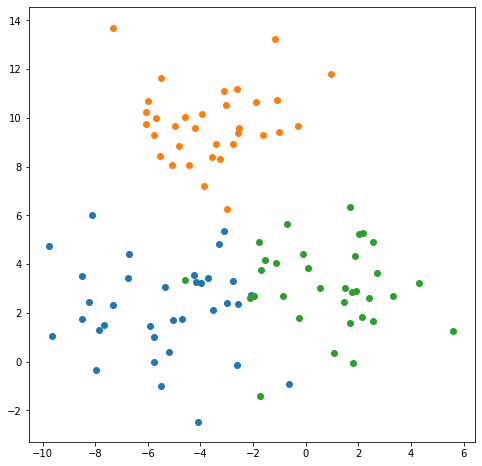

In [23]:
graph_classes(x,y)

In [194]:
tree = DecisionTreeClassifier(max_depth=2,criterion='entropy')
tree.fit(x,y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

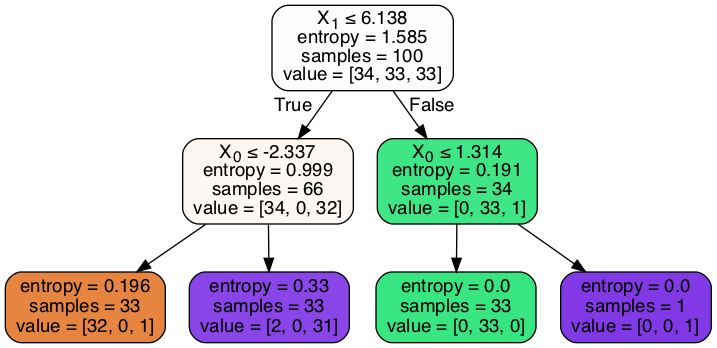

In [195]:
dot_data = StringIO()
export_graphviz(tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

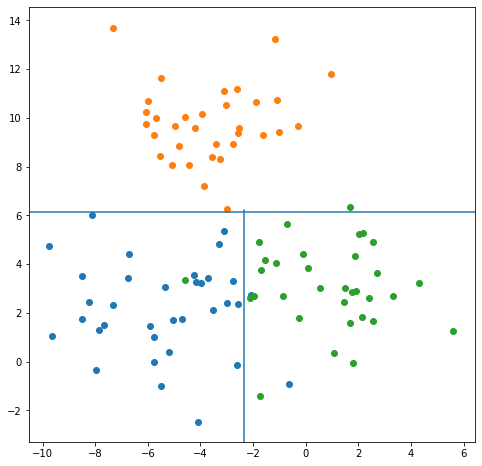

In [54]:
graph_classes(x,y)
plt.axhline(6.138)
plt.axvline(-2.337, ymax=(6.138-y_min)/(y_max-y_min))
#plt.axvline(1.314, ymin = (6.138-y_min)/(y_max-y_min))

In [141]:
tree.tree_.children_right

array([ 8,  5,  4, -1, -1,  7, -1, -1, 10, -1, -1])

In [102]:
tree.tree_.feature

array([ 1,  0,  1, -2, -2,  0, -2, -2,  0, -2, -2])

In [94]:
tree.tree_.threshold

array([ 6.13822365, -2.3369869 ,  3.32442856, -2.        , -2.        ,
       -0.4407704 , -2.        , -2.        ,  1.31409189, -2.        ,
       -2.        ])

The node by node information of the final decision model - that is things like which variable the tree is splitting on, what the decision threshold is, whether the node has any children - is stored, appropriately, in a data structure called a tree. Sensible as this is, it means that the nodes of different trees may be stored at different indexes depending on the overall structure of the tree. E.G the first child node to the right might be stored at index 2 for a tree with just one child level, or it could be stored at any nearly any other index value depending on how deep the left child sub tree is, which nodes don't have children, etc. To make this function that will dynamically plot out where the decision thresholds are, I need a way to sensibly navigate the tree, hitting every node in a sensible order. I did this recursively and always keeping to the left first, much like the structure of tree.

1. Ensure that a given level has children, if it does graph the line representing the decision threshold (this needs to be broken out for whether it was an x or y threshold, but the two halves of the function are the same, with just the x/y swapped)
2. Start with the left children - the new node is the left child of the original node
3. Call the function recursively on the new node, setting the last threshold as a new x or y direction limit for the graphing
4. When the recursive functions cascade out, the same thing is done with the right child
5. Pass to close the function

In [223]:
def plot_children(tree,node,xmin,xmax,ymin,ymax,xtotal,ytotal,xbase,ybase):
    if tree.tree_.children_left[node] != -1 or tree.tree_.children_right[node] != -1:
        if tree.tree_.feature[node] == 0:
            value = tree.tree_.threshold[node]
            plt.axvline(value,ymax=(ymax-ybase)/ytotal,ymin=(ymin-ybase)/ytotal)

            new_node = tree.tree_.children_left[node]
            plot_children(tree,new_node,xmin,value,ymin,ymax,xtotal,ytotal,xbase,ybase)
        

            new_node = tree.tree_.children_right[node]
            plot_children(tree,new_node,value,xmax,ymin,ymax,xtotal,ytotal,xbase,ybase)
        else:
            value = tree.tree_.threshold[node]
            plt.axhline(value,xmax=(xmax-xbase)/xtotal,xmin=(xmin-xbase)/xtotal)

            new_node = tree.tree_.children_left[node]
            plot_children(tree,new_node,xmin,xmax,ymin,value,xtotal,ytotal,xbase,ybase)
            

            new_node = tree.tree_.children_right[node]
            plot_children(tree,new_node,xmin,xmax,value,ymax,xtotal,ytotal,xbase,ybase)
    pass


In [136]:
def tree_grid_visualizer(x,y,params):
    tree = DecisionTreeClassifier(criterion=params.get('criterion','entropy'),
                                 max_depth=params.get('max_depth',None),
                                 max_leaf_nodes = params.get('max_leaf_nodes',None),
                                 min_samples_leaf=params.get('min_samples_leaf',1))
    tree.fit(x,y)
    xmax = max(x[:,0])+.1
    xmin = min(x[:,0])-.1
    ymax = max(x[:,1])+.1
    ymin = min(x[:,1])-.1
    
    fig = plt.figure(figsize=(8,8))
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

    for n in set(y):
        plt.scatter(x[y==n,0],x[y==n,1])
        
    plot_children(tree,0,xmin,xmax,ymin,ymax,(xmax-xmin),(ymax-ymin),xmin,ymin)
    
    

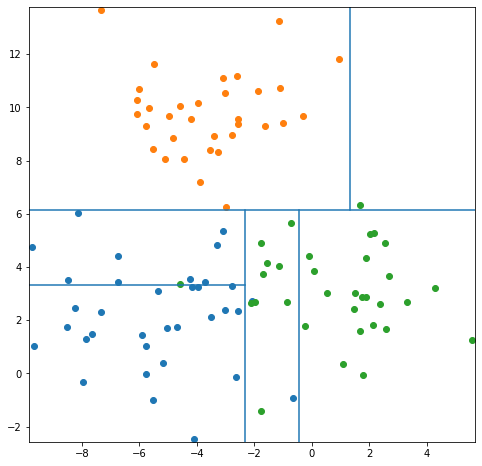

In [168]:
tree_grid_visualizer(x,y,{'max_depth':3})

In [190]:
x2, y2 = make_blobs(cluster_std=2.5,centers=2,random_state=29)
x3, y3 = make_blobs(cluster_std=2.8,centers=2,random_state=31)
x_comb = np.concatenate([x2,x3])
y_comb = np.concatenate([y2,y3])

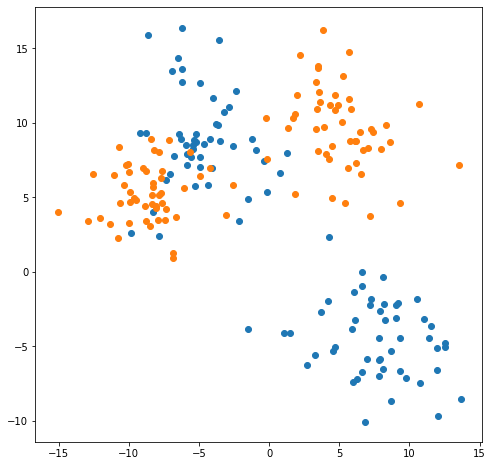

In [191]:
graph_classes(x_comb,y_comb)

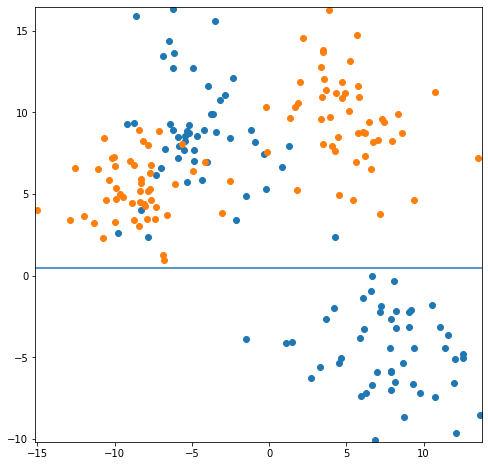

In [201]:
tree_grid_visualizer(x_comb,y_comb,{'max_depth':1,'min_samples_leaf':3})

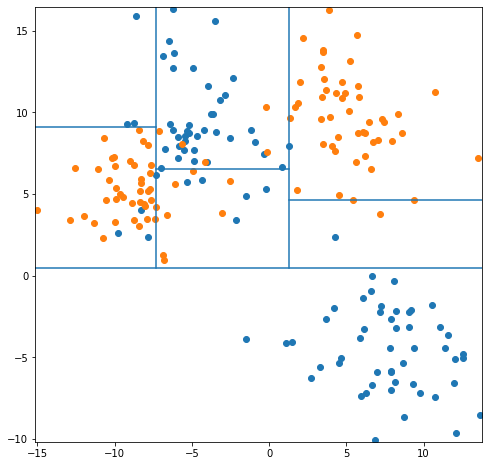

In [204]:
tree_grid_visualizer(x_comb,y_comb,{'max_depth':4,'min_samples_leaf':3})

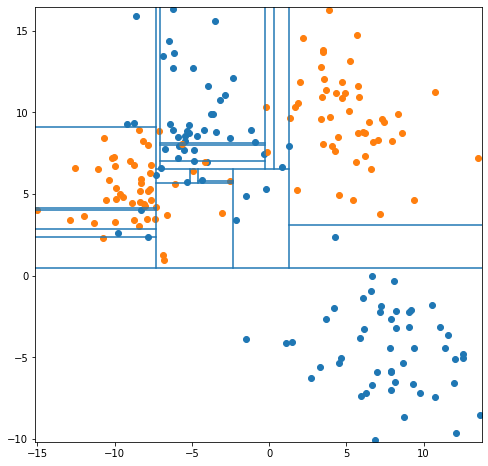

In [206]:
tree_grid_visualizer(x_comb,y_comb,{'max_depth':9})

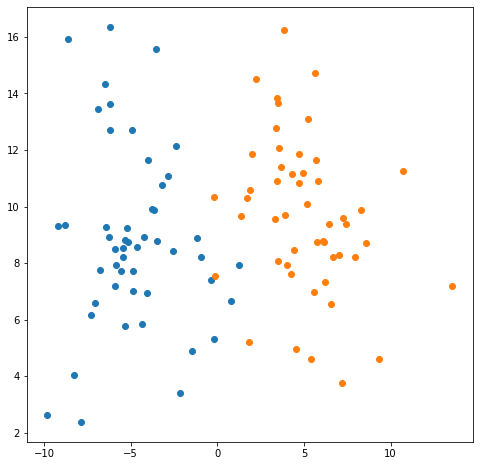

In [218]:
graph_classes(x3,y3)

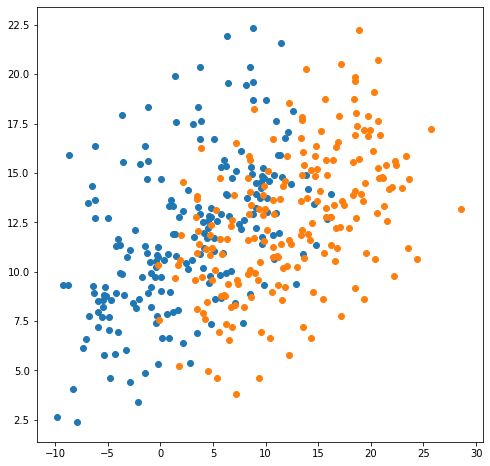

In [221]:
simp_x =np.concatenate([x3,x3+[5,2],x3+[10,4],x3+[15,6]])
simp_y = np.concatenate([y3,y3,y3,y3])
graph_classes(simp_x,simp_y)

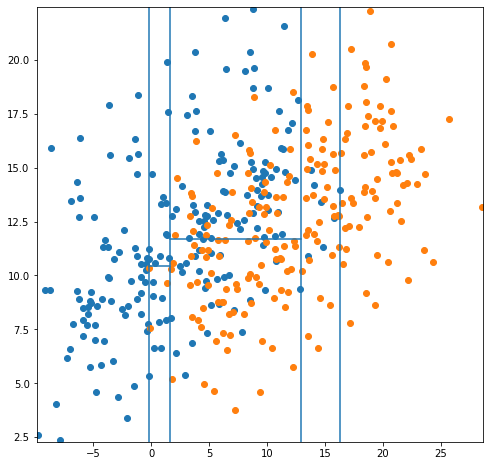

In [224]:
tree_grid_visualizer(simp_x,simp_y,{'max_depth':3})